# Phase 0 · Step 0.1 — Initialize a clean scaffold & pin requirements

### What we did (and why)

* **Created a minimal, reproducible project structure** so everything has a predictable place. This keeps exploration (notebooks) separate from reusable logic (src) and data.
* **Pinned a minimal `requirements.txt`** to avoid common Colab/local breakages (e.g., NumPy 2.x vs scikit-learn incompatibilities; Prophet’s Stan build quirks). We’ll add anything else later *only when needed*.

### What got created

* Project folder at `/content/media-forecast-causal` with:

  * `data/{raw,processed}` – source vs. curated outputs
  * `notebooks/` – for your step-by-step workflows
  * `src/` – for reusable functions once we stabilize logic
  * `README.md` – quick rationale and next steps
  * `requirements.txt` – pinned, Colab-friendly versions


In [ ]:
import os, pathlib, textwrap, shutil

# === Define base path ===
BASE = pathlib.Path("/content/media-forecast-causal")

# If it already exists from earlier runs, wipe it for a clean start
if BASE.exists():
    shutil.rmtree(BASE)

# Create folders
dirs = [
    BASE / "data" / "raw",
    BASE / "data" / "processed",
    BASE / "notebooks",
    BASE / "src",
]
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
# === Minimal requirements pinned for Colab friendliness ===
requirements_txt = textwrap.dedent("""
numpy==1.26.*
pandas==2.1.*
scikit-learn==1.3.*
statsmodels==0.14.*
pmdarima==2.0.4
prophet==1.1.5
mlflow==2.14.*
causalimpact==0.2.12
matplotlib==3.8.*
plotly==5.24.*
streamlit==1.36.*
""").strip()

In [ ]:
readme_md = textwrap.dedent("""
# Media Forecasting & Causal Impact — Project

**Phase 0 (Setup):** This repo is initialized with a minimal, reproducible structure and a **pinned requirements.txt** that works cleanly on **Python 3.10** (recommended for Colab Pro).

## Structure
```

media-forecast-causal/
data/
raw/
processed/
notebooks/
src/
requirements.txt
README.md

```

## Why these pins?
- `numpy==1.26.*` and `scikit-learn==1.3.*` avoid NumPy 2.x incompatibilities.
- `prophet==1.1.5` is a stable baseline; first fit compiles Stan (may take a few minutes).
- `statsmodels==0.14.*` pairs well with SARIMAX.
- `causalimpact==0.2.12` for Bayesian structural time series.
- `mlflow>=2.14` for experiment tracking later.

## Next (Phase 0, Step 0.2):
- Simulate a daily dataset with known treatment (brand-burst) so we can validate forecasting and causal estimates end-to-end.
""").strip()

In [ ]:
# Write files
(BASE / "requirements.txt").write_text(requirements_txt)
(BASE / "README.md").write_text(readme_md)

# Quick check: list the structure
for root, dirs, files in os.walk(BASE):
    level = root.replace(str(BASE), "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  {f}")

media-forecast-causal/
  requirements.txt
  README.md
  src/
  notebooks/
  data/
    processed/
    raw/


## 🎯 Problem Framing for Our Workflow

**Business Context:**
A retailer runs **always-on media campaigns** across Search, Social, Display, and Email. Mid-year, the marketing team invests heavily in a **3-week brand campaign** to boost awareness and conversions. The company also runs promotions and faces pricing fluctuations.

**The Challenge:**

1. **Forecasting Need:**

   * Leadership requires **short-term forecasts** of daily revenue/conversions to plan staffing, inventory, and budget allocation.
   * They want to know: *“Can we reliably predict the next 2–4 weeks given media spend and external factors?”*

2. **Causal Need:**

   * The marketing team asks: *“Did our brand burst actually lift revenue, or would sales have risen anyway due to trends/seasonality?”*
   * They need **causal attribution** of the campaign to prove ROI, justify spend, and plan future bursts.

**Pain Point:**
Traditional reports only show raw revenue trends, which can be misleading due to overlapping effects (seasonality, promos, price changes). Without rigorous **forecasting + causal inference**, decisions are based on gut-feel and noisy metrics.

**Our Workflow’s Goal:**

* **Forecast daily conversions/revenue** using models that account for exogenous drivers (SARIMAX, Prophet).
* **Quantify the incremental lift** from the brand burst using Bayesian Structural Time Series (CausalImpact).
* Provide **business-ready metrics**: forecast accuracy, incremental ROI (iROAS), and risk/uncertainty bands.
* Deliver results via a **Streamlit dashboard** and log experiments in **MLflow** for reproducibility.

---
TLDR:
> *“We’re simulating 3 years of daily business data for a retailer with multiple media channels and one major brand burst. This dataset mirrors the messy, overlapping drivers companies deal with, and it sets up the forecasting + causal ROI problem we aim to solve.”*

In [ ]:
import numpy as np
import pandas as pd

def generate_simulated_media(seed: int = 42, years: int = 3) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    days = 365 * years
    dates = pd.date_range("2021-01-01", periods=days, freq="D")

    # === Baseline components ===
    weekly = np.sin(2*np.pi*np.arange(days)/7) * 5     # weekly seasonality
    trend = np.linspace(0, 50, days)                   # long-term growth
    noise = rng.normal(0, 5, size=days)                # random variation

    # === Media spends (random walk style) ===
    def spend_walk(base, vol):
        x = np.cumsum(rng.normal(0, vol, size=days)) + base
        return np.clip(x, 0, None)

    search = spend_walk(50, 2)
    social = spend_walk(35, 1.5)
    display = spend_walk(20, 1.0)
    email = spend_walk(5, 0.5)

    # === Other drivers ===
    price_index = 100 + rng.normal(0, 0.7, size=days)      # small fluctuations
    promo_flag = (rng.random(days) < 0.05).astype(int)     # ~5% of days
    holiday_flag = ((pd.Series(dates).dt.weekday >= 5).astype(int)).values  # weekends

    # === Brand burst campaign (treatment) ===
    burst_start = int(days * 0.5)     # halfway point
    burst_len = 21                    # 3 weeks
    brand_burst_flag = np.zeros(days, dtype=int)
    brand_burst_flag[burst_start:burst_start+burst_len] = 1

    # === True outcome generation ===
    baseline = 100 + weekly + trend + noise
    y = (
        baseline
        + 0.05 * search
        + 0.03 * social
        + 0.02 * display
        + 0.01 * email
        - 0.4 * (price_index - 100)
    )
    # Inject true lift during the brand burst (+12%)
    y *= (1 + 0.12 * brand_burst_flag)
    y = np.clip(y, 1, None)

    df = pd.DataFrame({
        "date": dates,
        "y": y,
        "price_index": price_index,
        "promo_flag": promo_flag,
        "holiday_flag": holiday_flag,
        "search_spend": search,
        "social_spend": social,
        "display_spend": display,
        "email_spend": email,
        "brand_burst_flag": brand_burst_flag,
    }).set_index("date")

    return df

In [ ]:
# === Generate and save ===
df = generate_simulated_media()
path = "/content/media-forecast-causal/data/processed/simulated_media.csv"
df.to_csv(path)

print(f"Saved simulated dataset to: {path}")
print("Shape:", df.shape)
display(df.head(10))

Saved simulated dataset to: /content/media-forecast-causal/data/processed/simulated_media.csv
Shape: (1095, 9)


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag
date,,,,,,,,,
2021-01-01,106.005929,99.257165,0,0,52.452586,36.089148,21.009100,5.972381,0
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0
2021-01-06,93.184852,100.469430,1,0,63.291516,30.724072,19.071699,6.190972,0
2021-01-07,101.740502,99.627085,0,0,64.519714,30.453611,19.349043,6.049301,0
2021-01-08,103.374788,100.011554,0,0,65.716408,30.474719,18.854295,6.354802,0
2021-01-09,108.479952,100.991861,0,1,66.755729,30.151995,19.408248,5.540303,0


# Phase 0 · Step 0.3 — Visual sanity checks (target + intervention)

**Why this step:** before modeling, we want to *verify the dataset looks right*: date range, nulls, and that the **brand-burst window** exists where we expect. Then we’ll **plot the target** (`y`) and visually highlight the intervention period so you can literally “see” what later causal analysis will try to quantify.

---

### 0.3.a — Load data & quick health checks

**What this does:**

* Loads the CSV you saved in Step 0.2
* Prints shape, date range, null counts, and first 5 rows
* Confirms we have the `brand_burst_flag`

In [ ]:
import pandas as pd

path = "/content/media-forecast-causal/data/processed/simulated_media.csv"
df = pd.read_csv(path, parse_dates=["date"]).set_index("date")

print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("\nColumns:", list(df.columns))
print("\nNull counts:\n", df.isna().sum())
display(df.head())

Shape: (1095, 9)
Date range: 2021-01-01 → 2023-12-31

Columns: ['y', 'price_index', 'promo_flag', 'holiday_flag', 'search_spend', 'social_spend', 'display_spend', 'email_spend', 'brand_burst_flag']

Null counts:
 y                   0
price_index         0
promo_flag          0
holiday_flag        0
search_spend        0
social_spend        0
display_spend       0
email_spend         0
brand_burst_flag    0
dtype: int64


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag
date,,,,,,,,,
2021-01-01,106.005929,99.257165,0,0,52.452586,36.089148,21.009100,5.972381,0
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0


### 0.3.b — Plot target (`y`) and shade the brand-burst window

**What this does:**

* Finds the **start & end dates** where `brand_burst_flag == 1`
* Plots `y` over time
* Adds a **7-day moving average** to reduce noise (just for visual clarity)
* **Shades** the intervention period in the plot, so you can see the lift pattern

In [ ]:
import matplotlib.pyplot as plt

# Identify the intervention window from the flag
burst_idx = df.index[df["brand_burst_flag"] == 1]
if len(burst_idx) > 0:
    burst_start = burst_idx.min()
    burst_end   = burst_idx.max()
    print(f"Brand burst window: {burst_start.date()} → {burst_end.date()} (inclusive)")
else:
    print("No brand_burst_flag detected as 1; please re-run Step 0.2 to simulate data.")

Brand burst window: 2022-07-02 → 2022-07-22 (inclusive)


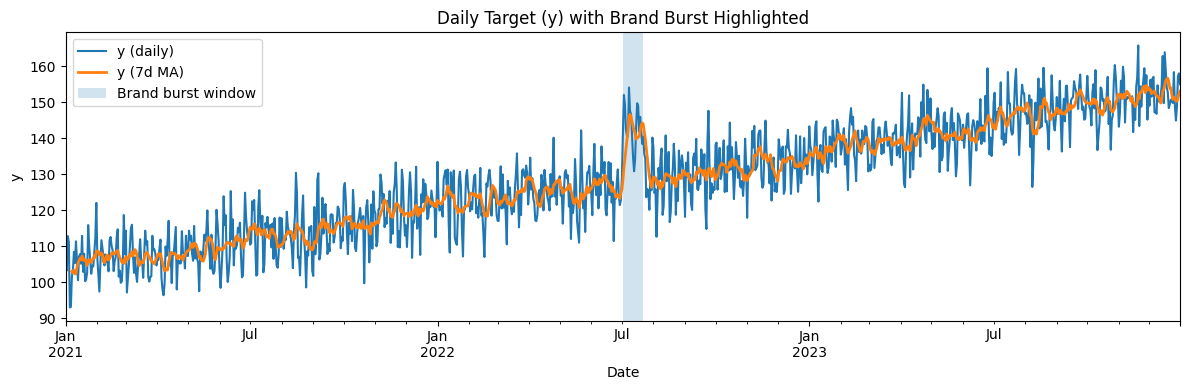

In [ ]:
# Make a simple plot
fig, ax = plt.subplots(figsize=(12, 4))

df["y"].plot(ax=ax, label="y (daily)")
df["y"].rolling(7).mean().plot(ax=ax, linewidth=2, label="y (7d MA)")

# Shade intervention window if present
if len(burst_idx) > 0:
    ax.axvspan(burst_start, burst_end, alpha=0.2, label="Brand burst window")

ax.set_title("Daily Target (y) with Brand Burst Highlighted")
ax.set_xlabel("Date")
ax.set_ylabel("y")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Phase 0 · Step 0.4 — Quick EDA sanity checks

**Why this step:** before we close Phase 0, we want to be sure the simulated dataset is *plausible*:

* Outcome distribution (is `y` positive and in a realistic range?)
* Media spend distributions (are channels on different scales?)
* Correlation structure (do we see sensible relationships between media and `y`?)

This isn’t modeling yet — just making sure our synthetic world resembles a real business scenario.

### 0.4.a — Basic descriptive stats

In [ ]:
# Summary stats of target + media channels
print("=== Descriptive statistics ===")
display(df[["y","search_spend","social_spend","display_spend","email_spend"]].describe())

# Check proportion of promo and holiday flags
print("\nPromo day proportion:", df["promo_flag"].mean())
print("Holiday day proportion:", df["holiday_flag"].mean())
print("Brand burst days:", df["brand_burst_flag"].sum())

=== Descriptive statistics ===


,y,search_spend,social_spend,display_spend,email_spend
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,128.465611,20.327587,59.834364,24.093222,1.742859
std,15.463799,23.725899,23.425436,9.923766,2.513084
min,93.040615,0.000000,14.001452,1.799022,0.000000
25%,116.119725,0.000000,41.100946,15.277619,0.000000
50%,128.621010,1.385067,60.348751,23.133263,0.000000
75%,141.036575,42.546255,78.911912,32.345077,3.627046
max,165.767355,69.946584,106.198634,43.760062,10.744569



Promo day proportion: 0.052054794520547946
Holiday day proportion: 0.2867579908675799
Brand burst days: 21


---

### 0.4.b — Histograms of key variables

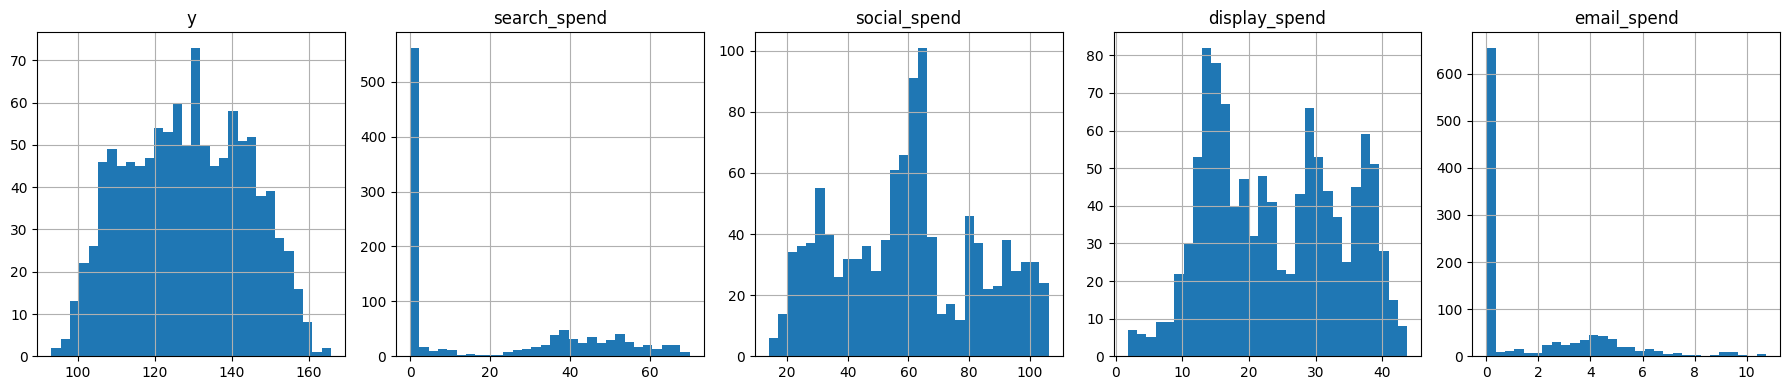

In [ ]:
import matplotlib.pyplot as plt

cols_to_plot = ["y","search_spend","social_spend","display_spend","email_spend"]

fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(18,4))
for ax, col in zip(axes, cols_to_plot):
    df[col].hist(bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

### 0.4.c — Correlation heatmap

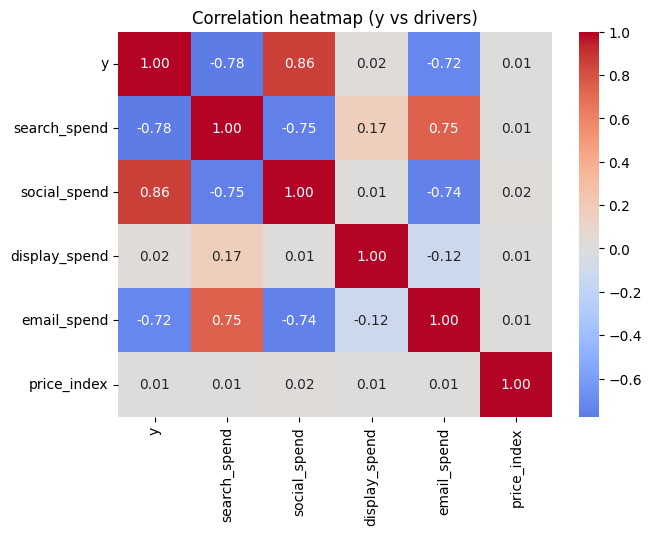

In [ ]:
import seaborn as sns

corr = df[["y","search_spend","social_spend","display_spend","email_spend","price_index"]].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation heatmap (y vs drivers)")
plt.show()

### What to look for

* `y` should be reasonably centered (not exploding to huge values).
* Media spends have different magnitudes (search > social > display > email).
* Correlations: positive with media spends, negative with price index.

If all of that looks consistent, we’ve **validated our synthetic problem setting**. That means Phase 0 (Setup + Data Simulation + Sanity Checks) is complete 🎉.

In [ ]:
import os, pathlib, shutil, zipfile
import numpy as np, pandas as pd

# === Base project path ===
BASE = pathlib.Path("/content/media-forecast-causal")

# Recreate folder structure (clean slate)
if BASE.exists():
    shutil.rmtree(BASE)

dirs = [
    BASE / "data" / "raw",
    BASE / "data" / "processed",
    BASE / "notebooks",
    BASE / "src",
]
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

# === Simulate dataset (same as earlier Step 0.2) ===
def generate_simulated_media(seed: int = 42, years: int = 3) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    days = 365 * years
    dates = pd.date_range("2021-01-01", periods=days, freq="D")

    # Baseline components
    weekly = np.sin(2*np.pi*np.arange(days)/7) * 5
    trend = np.linspace(0, 50, days)
    noise = rng.normal(0, 5, size=days)

    # Media spends
    def spend_walk(base, vol):
        x = np.cumsum(rng.normal(0, vol, size=days)) + base
        return np.clip(x, 0, None)

    search = spend_walk(50, 2)
    social = spend_walk(35, 1.5)
    display = spend_walk(20, 1.0)
    email = spend_walk(5, 0.5)

    # Other drivers
    price_index = 100 + rng.normal(0, 0.7, size=days)
    promo_flag = (rng.random(days) < 0.05).astype(int)
    holiday_flag = ((pd.Series(dates).dt.weekday >= 5).astype(int)).values

    # Brand burst
    burst_start = int(days * 0.5)
    burst_len = 21
    brand_burst_flag = np.zeros(days, dtype=int)
    brand_burst_flag[burst_start:burst_start+burst_len] = 1

    # Outcome generation
    baseline = 100 + weekly + trend + noise
    y = (
        baseline
        + 0.05 * search
        + 0.03 * social
        + 0.02 * display
        + 0.01 * email
        - 0.4 * (price_index - 100)
    )
    y *= (1 + 0.12 * brand_burst_flag)
    y = np.clip(y, 1, None)

    df = pd.DataFrame({
        "date": dates,
        "y": y,
        "price_index": price_index,
        "promo_flag": promo_flag,
        "holiday_flag": holiday_flag,
        "search_spend": search,
        "social_spend": social,
        "display_spend": display,
        "email_spend": email,
        "brand_burst_flag": brand_burst_flag,
    }).set_index("date")

    return df

# Save dataset
df = generate_simulated_media()
data_path = BASE / "data" / "processed" / "simulated_media.csv"
df.to_csv(data_path)
print("Dataset saved at:", data_path, "Shape:", df.shape)

# === Write README and requirements for Phase 0 ===
(BASE / "README.md").write_text("# Media Forecasting & Causal Impact — Phase 0 complete\n")
(BASE / "requirements.txt").write_text("numpy==1.26.*\npandas==2.1.*\nscikit-learn==1.3.*\n")

# === Zip entire project ===
zip_path = "/content/media-forecast-causal_phase0.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(BASE):
        for f in files:
            full_path = pathlib.Path(root) / f
            rel_path = full_path.relative_to(BASE.parent)
            z.write(full_path, rel_path)

print("Zipped project at:", zip_path)

Dataset saved at: /content/media-forecast-causal/data/processed/simulated_media.csv Shape: (1095, 9)
Zipped project at: /content/media-forecast-causal_phase0.zip
